In [1]:
#@title Mount Google Drive (Optional) {display-mode: "form"}

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title Library Imports {display-mode: "form"}

# Imports
import numpy as np
import pandas as pd
import cv2
import os

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#@title Load Human Pose Estimation Model {display-mode: "form"}

# Getting the OpenPose Body25 trained model files from source links.
!wget -qq "https://drive.google.com/uc?export=download&id=1j9-3eOVjLvEMHv46OKluZkO4Ja7lquw6" -O "pose_deploy.prototxt"
!wget -qq "https://drive.google.com/uc?export=download&id=12UYy-kwnT6OymUs7rQ-g5IeADO3Nh0Ca" -O "pose_iter_584000.caffemodel"

# Source for code: https://www.learnopencv.com/deep-learning-based-human-pose-estimation-using-opencv-cpp-python/

# Specifying the paths for the two files.
protoFile = "pose_deploy.prototxt"
weightsFile = "pose_iter_584000.caffemodel"

# Reading the network into memory.
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

In [4]:
#@title Define Necessary Functions {display-mode: "form"}

# Defining a function to find body points in an image/video frame.

def find_skeleton(frame):

    frame_copy = np.copy(frame)

    # Specifying the input image dimensions.
    inWidth = 368
    inHeight = 368

    # Prepare the frame to be fed to the network.
    inpBlob = cv2.dnn.blobFromImage(frame_copy, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

    # Set the prepared object as the input blob of the network.
    net.setInput(inpBlob)

    # Make predictions using the network.
    output = net.forward()

    H = output.shape[2]
    W = output.shape[3]

    # Empty list to store the detected keypoints
    points = []
    for i in range(15):
        
        # Confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # Scale the point to fit on the original image.
        x = (frame_copy.shape[1] * point[0]) / W
        y = (frame_copy.shape[0] * point[1]) / H

        if prob > 0.5:
            cv2.circle(frame_copy, (int(x), int(y)), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame_copy, f"{i}", (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)

            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))

        else:
            points.append(None)
    
    return frame_copy, points

    # cv2.imshow("Output-Keypoints",frame)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


# Defining a function to return the video filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_video.mp4", OUTPUT filepath will be "my_folder1/my_folder2/my_video_WITH_POINTS.mp4"

def new_vid_name(org_vid_path):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)

    new_vid_name_ext = vid_name+"_WITH_POINTS"+".mp4"
    new_vid_path = os.path.join(vid_path, new_vid_name_ext)

    return new_vid_path

In [5]:
# Provide the video filepath as a string below
# For example: "my_video.mp4" or "/content/drive/My Drive/my_folder/my_video.mp4"

my_video = "vertical_jump_side.mp4"

In [6]:
# Reading the video from filepath provided above and passing it through the find_skeleton method defined above.
# Source 1: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
# Source 2: https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

# Creating a VideoCapture object.
cap = cv2.VideoCapture(my_video)

# Checking if video can be accessed successfully.
if (cap.isOpened() == False): 
    print("Unable to read video!")

# Getting the video frame width and height.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Defining the codec and creating a VideoWriter object to save the output video at the same location.
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
new_my_video = new_vid_name(my_video)
out = cv2.VideoWriter(new_my_video, fourcc, 18, (frame_width, frame_height))

# Defining a new dataframe to store the skeleton point coordinates from each frame of the video.
video_points_df = pd.DataFrame(columns=list(range(1,26)))
frame_counter = 1

while(cap.isOpened()):
    
    # Grabbing each individual frame, frame-by-frame.
    ret, frame = cap.read()
    
    if ret==True:
        
        # Running human skeleton points detection on the grabbed frame.
        skeleton_frame, skeleton_frame_points = find_skeleton(frame)
        
        # Saving frame to output video using the VideoWriter object defined above.
        out.write(skeleton_frame)
        
        # Displaying the frame with body points detected.
        # cv2.imshow("Output Video", skeleton_frame)
        
        # Saving frame output skeleton point coordinates as a new row in above defined dataframe.
        video_points_df[frame_counter] = skeleton_frame_points
        frame_counter += 1
        
        # Exiting if "Q" key is pressed on the keyboard.
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    else:
        break

# Releasing the VideoCapture and VideoWriter objects, and closing the displayed frame.
cap.release()
out.release()
# cv2.destroyAllWindows()
print(f"Saved to {new_my_video}")

Saved to vertical_jump_side_WITH_POINTS.mp4


In [7]:
frame_counter

70

In [8]:
video_points_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
0,"(516, 709)","(516, 667)","(516, 667)","(493, 709)","(493, 709)","(493, 709)","(493, 709)","(493, 751)","(469, 751)","(469, 751)","(469, 793)","(469, 793)","(469, 834)","(446, 834)","(446, 834)","(446, 876)","(422, 876)","(422, 918)","(422, 918)","(399, 918)","(399, 918)","(399, 918)","(399, 918)","(422, 918)","(422, 876)","(446, 876)","(446, 834)","(469, 793)","(469, 751)","(469, 709)","(469, 667)","(469, 626)","(469, 584)",None,"(446, 542)","(446, 500)","(422, 500)","(422, 500)","(446, 500)","(446, 500)","(446, 500)","(469, 500)",None,"(493, 584)",None,"(516, 626)","(516, 667)","(516, 709)","(516, 709)","(516, 751)","(516, 751)","(516, 751)","(516, 751)","(516, 751)","(516, 709)","(516, 709)","(493, 709)","(493, 709)","(493, 709)","(493, 709)","(493, 667)","(493, 667)","(493, 667)","(493, 667)","(493, 667)","(493, 667)","(493, 667)","(493, 667)","(493, 667)"
1,"(610, 793)","(610, 793)","(610, 793)","(610, 793)","(586, 793)","(586, 834)","(563, 834)","(586, 834)","(586, 876)","(563, 876)","(586, 876)","(563, 918)","(563, 918)","(563, 960)","(563, 960)","(540, 1001)","(540, 1001)","(516, 1043)","(516, 1043)","(516, 1043)","(516, 1043)","(516, 1043)","(516, 1043)","(516, 1043)","(540, 1043)","(540, 1001)","(540, 960)","(540, 960)","(540, 918)","(563, 834)","(540, 793)","(540, 751)","(516, 709)","(540, 667)","(516, 626)","(516, 626)","(516, 584)","(516, 584)","(516, 584)","(516, 584)","(540, 584)","(540, 584)","(563, 626)","(586, 626)","(610, 667)","(610, 709)","(610, 793)","(633, 793)","(610, 876)","(610, 876)","(610, 876)","(610, 876)","(610, 876)","(610, 876)","(610, 876)","(610, 834)","(586, 834)","(610, 834)","(610, 834)","(586, 834)","(586, 793)","(586, 793)","(586, 793)","(586, 793)","(586, 793)","(586, 793)","(586, 793)","(586, 793)","(586, 793)"
2,None,None,None,None,None,"(563, 834)","(540, 876)","(563, 876)","(563, 876)","(563, 876)",None,None,None,None,"(563, 960)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"(469, 751)","(469, 709)",None,"(469, 667)","(469, 626)","(469, 626)","(469, 626)","(493, 626)","(493, 626)","(493, 626)",None,None,None,None,"(680, 751)",None,"(563, 876)","(563, 918)","(563, 918)",None,"(586, 876)",None,None,None,None,None,None,None,None,None,None,"(563, 793)","(563, 793)","(563, 793)","(586, 793)",None,"(586, 793)"
3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"(727, 1126)",None,None,None,None,None,None,None,None,None
5,"(610, 793)","(610, 793)","(610, 793)","(610, 793)","(610, 793)","(586, 793)","(586, 834)","(586, 834)","(586, 876)","(586, 876)","(586, 918)","(563, 918)","(563, 960)","(563, 960)","(540, 960)","(540, 1001)","(516, 1043)","(516, 1043)","(516, 1043)","(516, 1085)","(493, 1085)","(493, 1085)","(493, 1085)","(493, 1085)","(516, 1043)","(516, 1001)","(540, 1001)","(563, 960)","(563, 918)","(563, 834)","(563, 793)","(563, 709)","(586, 667)","(586, 667)",None,"(540, 584)","(540, 542)","(563, 542)","(563, 542)","(563, 542)","(586, 542)",None,"(633, 626)","(633, 626)","(657, 667)","(657, 709)","(563, 793)","(657, 793)","(657, 834)","(633, 876)","(633, 876)","(633, 876)","(633, 876)","(633, 876)","(633, 876)","(610, 834)","(610, 834)","(586, 834)","(586, 834)","

In [9]:
df = video_points_df.T.copy()

In [10]:
df.head(40)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,"(516, 709)","(610, 793)",None,None,None,"(610, 793)","(610, 1001)","(563, 1168)","(633, 1168)",None,"(610, 1419)",None,"(657, 1168)","(633, 1460)","(657, 1711)"
2,"(516, 667)","(610, 793)",None,None,None,"(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)",None,"(610, 1419)",None,"(657, 1168)","(633, 1419)","(633, 1711)"
3,"(516, 667)","(610, 793)",None,None,None,"(610, 793)","(586, 1001)","(540, 1210)","(657, 1168)",None,"(610, 1419)",None,"(657, 1168)","(633, 1419)","(633, 1711)"
4,"(493, 709)","(610, 793)",None,None,None,"(610, 793)","(586, 1001)","(516, 1168)","(657, 1168)",None,"(586, 1377)","(657, 1627)","(680, 1168)","(610, 1377)","(633, 1711)"
5,"(493, 709)","(586, 793)",None,None,None,"(610, 793)","(563, 1001)","(493, 1168)","(657, 1126)",None,"(563, 1377)","(657, 1627)","(680, 1126)","(586, 1377)","(633, 1711)"
6,"(493, 709)","(586, 834)","(563, 834)",None,None,"(586, 793)","(563, 1001)","(493, 1168)","(657, 1126)",None,"(563, 1377)","(657, 1627)","(680, 1126)","(563, 1377)","(633, 1711)"
7,"(493, 709)","(563, 834)","(540, 876)",None,None,"(586, 834)","(563, 1043)","(469, 1210)","(680, 1168)",None,"(563, 1377)","(657, 1627)","(680, 1168)","(563, 1419)","(633, 1711)"
8,"(493, 751)","(586, 834)","(563, 876)",None,None,"(586, 834)","(563, 1043)","(469, 1210)","(680, 1168)",None,"(563, 1377)","(633, 1627)","(704, 1168)","(540, 1419)","(633, 1711)"
9,"(469, 751)","(586, 876)","(563, 876)",None,None,"(586, 876)","(540, 1085)","(469, 1210)","(680, 1168)",None,"(563, 1377)","(657, 1627)","(704, 1168)","(540, 1419)","(633, 1711)"
10,"(469, 751)","(563, 876)","(563, 876)",None,None,"(586, 876)","(540, 1085)","(469, 1252)","(680, 1168)",None,"(540, 1377)","(657, 1627)","(704, 1168)","(516, 1419)","(633, 1753)"


Text(266.26925221469514, 0.5, 'Y')

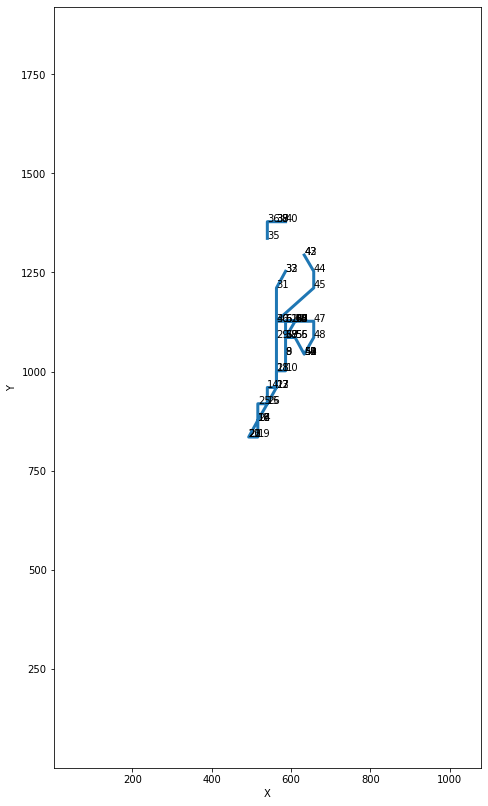

In [11]:
df_x = []
df_y = []

for points in df.loc[:, 5]:
    if points != None:
        x, y = points
        y = frame_height - y
    else:
        x = None
        y = None
    df_x.append(x)
    df_y.append(y)


plt.figure(figsize=(14,14))

plt.plot(df_x, df_y, linewidth=3)
plt.xlim([1, 1080])
plt.ylim([1, 1920])

for i in range(len(df)):
    if df_x[i]!=None:
        plt.text(x=df_x[i], y=df_y[i], s=str(i))


plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

plt.xlabel("X")
plt.ylabel("Y")

Text(0, 0.5, 'Y')

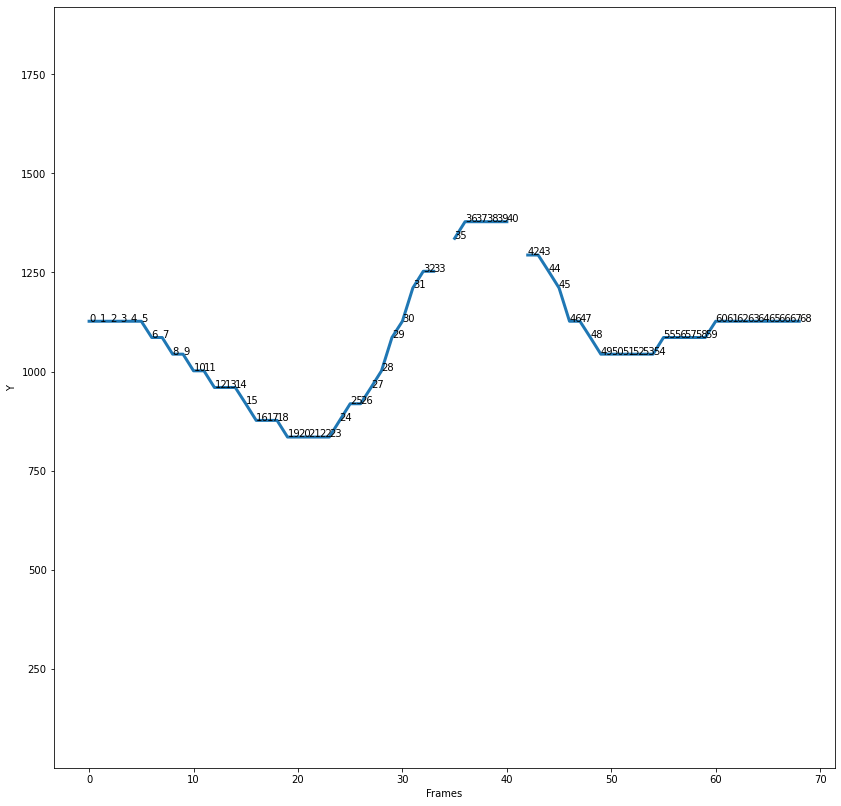

In [13]:
plt.figure(figsize=(14,14))

plt.plot(range(frame_counter-1), df_y, linewidth=3)
# plt.xlim([1, 1080])
plt.ylim([1, 1920])

for i in range(len(df)):
    if df_x[i]!=None:
        plt.text(x=i, y=df_y[i], s=str(i))


# plt.gca().set_aspect('equal', adjustable='box')
# plt.draw()

plt.xlabel("Frames")
plt.ylabel("Y")